# importing libraries 


In [119]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
from category_encoders import BinaryEncoder

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

print("Successfully Imported!")


Successfully Imported!


# Loading the Data

In [87]:
def loadData(crop_production_path, soil_analysis_path, water_usage_path):
    """
    Load and merge crop production, soil analysis, and water usage data sets.

    Args:
    crop_production_path (str): File path of the crop production data set.
    soil_analysis_path (str): File path of the soil analysis data set.
    water_usage_path (str): File path of the water usage data set.
    
    Returns:
    df_merged (DataFrame): Merged data set containing information from crop production, soil analysis, and water usage.
    """
    # Load crop production data
    df_crop_production = pd.read_csv(crop_production_path)
    
    # Load soil analysis data
    df_soil_analysis = pd.read_csv(soil_analysis_path)
    
    # Load water usage data
    df_water_usage = pd.read_csv(water_usage_path)
    
    # Merge crop production and soil analysis data based on the 'District' column
    merge_soil_crop_production = df_crop_production.merge(df_soil_analysis, on=['District'])
    
    # Merge the merged soil-crop production data with water usage data based on the 'District' and 'Crop' columns
    df_merged = merge_soil_crop_production.merge(df_water_usage, on=['District', 'Crop'])
    # Rename the columns 
    df_merged.columns = ['district','crop', 'season', 'area_ha', 'yield_quintals', 'prodcution', 'soil_type', 'pH_level', 'organic_matter_per'
                  , 'Nitrogen_kg_ha', "Phosphorous_kg_ha", 'Potassium_kg_ha', 'irrigation_method', 'water_consumption_ltr_ha','water_availability']
    
    
    print("Data successfully loaded")
    # Return the merged data set
    return df_merged


In [88]:
df_merged = loadData("crop_production_data.csv", "soil_analysis_data.csv", "water_usage_data.csv")

Data successfully loaded


In [89]:
df_merged.head()

,district,crop,season,area_ha,yield_quintals,prodcution,soil_type,pH_level,organic_matter_per,Nitrogen_kg_ha,Phosphorous_kg_ha,Potassium_kg_ha,irrigation_method,water_consumption_ltr_ha,water_availability
0,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,9738.809833,10557.488279
1,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,13591.319448,14448.126887
2,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Drip Irrigation,8811.686999,8512.323275
3,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,8860.161716,9434.989877
4,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Chalky (Calcareous),7.305740,2.095212,32.246094,17.450967,40.172205,Sprinkler Irrigation,9738.809833,10557.488279


In [90]:

def exploreData(df_merged):
    """
    Explore a merged DataFrame and create a summary DataFrame that illustrates the exploration.

    Args:
    df_merged (DataFrame): The merged DataFrame to explore.

    Returns:
    summary_df (DataFrame): A DataFrame summarizing the exploration results.
    """
    # Initialize the summary DataFrame
    summary_df = pd.DataFrame(columns=['Column Name', 'Count', 'Mean', 'Variance', 'Cardinality', 'Data Type', 'Mode', 'Nulls'])

    # Iterate over each column
    for column in df_merged.columns:
        # Calculate mean and variance for numeric columns
        if pd.api.types.is_numeric_dtype(df_merged[column]):
            mean_value = df_merged[column].mean()
            variance_value = df_merged[column].var()
            mode_value = None
        else:
            mean_value = "N/A"
            variance_value = "N/A"
            mode_value = df_merged[column].mode().values[0] if len(df_merged[column].mode()) > 0 else None

        # Get the count of non-null values in each column
        count = df_merged[column].count()

        # Get the cardinality of object-type columns
        if df_merged[column].dtype == 'object':
            cardinality = df_merged[column].nunique()
        else:
            cardinality = None

        # Get the data type of the column
        data_type = str(df_merged[column].dtype)

        # Get the number of null values in each column
        nulls_count = df_merged[column].isnull().sum()

        # Add the column information to the summary DataFrame
        summary_df = summary_df.append({
            'Column Name': column,
            'Count': count,
            'Mean': mean_value,
            'Variance': variance_value,
            'Cardinality': cardinality,
            'Data Type': data_type,
            'Mode': mode_value,
            'Nulls': nulls_count
        }, ignore_index=True)

    return summary_df


In [91]:
exploreData(df_merged)

,Column Name,Count,Mean,Variance,Cardinality,Data Type,Mode,Nulls
0,district,433580,N/A,N/A,10,object,Udaipur,0
1,crop,433580,N/A,N/A,23,object,Pulses,0
2,season,433580,N/A,N/A,2,object,Kharif,0
3,area_ha,433580,15088.763559,7640424.923607,None,float64,None,0
4,yield_quintals,433580,37.613585,68.273773,None,float64,None,0
5,prodcution,433580,5675.128228,2655255.688258,None,float64,None,0
6,soil_type,433580,N/A,N/A,8,object,Black lava soil,0
7,pH_level,433580,7.498173,0.264746,None,float64,None,0
8,organic_matter_per,433580,1.992217,0.267799,None,float64,None,0
9,Nitrogen_kg_ha,433580,29.89385,26.878701,None,float64,None,0


# Transforming the data

In [92]:

def detect_outliers(df):
    """
    Detects outliers in the numerical features of the input DataFrame.

    Outliers are detected using the interquartile range (IQR) method. Any value that falls below the lower limit (1.5 times the IQR below the first quartile) or above the upper limit (1.5 times the IQR above the third quartile) is considered an outlier and is removed from the DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: DataFrame with outliers removed.

    """

    table = {}
    numerical_features = df.select_dtypes(include=['int', 'float']).columns

    for featureName in numerical_features:
        print(f'Column: {featureName}')

        # Get the feature description which includes min, max, 25%, 75%, and more
        featureDescription = df[featureName].describe()

        # Calculate the 1st and 3rd quartiles, and the IQR value
        firstQuantile = featureDescription['25%']
        thirdQuantile = featureDescription['75%']
        IQR = thirdQuantile - firstQuantile

        # Calculate the upper and lower limits for outliers
        maxRange = thirdQuantile + 1.5 * IQR
        minRange = firstQuantile - 1.5 * IQR

        table[featureName] = [maxRange, minRange]

        print(f"The upper limit is {maxRange}")
        print(f"The lower limit is {minRange}")

        # Count the number of outliers in each feature
        outlier_count = df.query(f'{featureName} > {maxRange} or {featureName} < {minRange}').shape[0]
        print('Number of outliers:', outlier_count)
        print('--------------------------')

        # Remove outliers from the DataFrame
        df = df[(df[featureName] >= minRange) & (df[featureName] <= maxRange)]

    return df


In [93]:
def scale_features(df, numerical_features):
    """
    Performs standard scaling on numerical features in the DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.
        numerical_features (list): List of numerical feature names to be scaled.

    Returns:
        pandas.DataFrame: Scaled DataFrame.
    """
    scaler = StandardScaler()
    for feature in numerical_features:
        df[feature] = scaler.fit_transform(df[[feature]]) 
    return df

def encode_features(df, categorical_features):
    """
    Performs binary encoding on categorical features in the DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.
        categorical_features (list): List of categorical feature names to be encoded.

    Returns:
        pandas.DataFrame: DataFrame with binary-encoded categorical features.
    """
    bin_encode = BinaryEncoder(cols=categorical_features)
    df_encoded = bin_encode.fit_transform(df)
    return df_encoded

def transform_dataframe(df):
    """
    Transforms the input DataFrame through encoding and scaling.

    The encoding method used is binary encoding, which is suitable for categorical features with high cardinality and produce zero-baised dataframe.
    The scalling technique used is standard scaler, which is appropriate for numerical features with a normal distribution.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: Transformed DataFrame with encoded and scaled features.

    Notes:
        If the input DataFrame contains null values, they will be dropped before the transformation.
    """
    
    # Data preprocessing - Removing duplicates and null values.
    df = df.drop_duplicates()
    if(df.isnull().values.any()):
        df = df.dropna()

    print("duplicates and nulls removed")
    # Drop uneeded features.
    '''
    Area (hectares): 
                    This column is dropped because the water consumption is already measured in liters per hectare, so including 
                    the area would be redundant and unnecessary for predicting water consumption.
    Yield (quintals): 
                    This column is dropped because it represents the output quantity from the crop, which is not directly related 
                    to water consumption. The yield is typically dependent on factors such as crop genetics, fertilization, and 
                    other agronomic practices, rather than just the water consumption.
    Production (metric tons): 
                            This column is dropped for a similar reason as the yield. Production represents the total quantity of 
                            crop harvested, which is not solely determined by water consumption but is influenced by various factors 
                            including area, yield, and other agricultural practices.
    Season: 
            This column is dropped because it represents the season when the crop was harvested, which is not directly related to 
            the water consumption. The water consumption would depend on factors such as irrigation practices and climatic conditions 
            during the growth period, rather than the specific season of harvest.
    '''
    
    #  Dropping unnecessary features
    drop_columns = ['area_ha', 'yield_quintals', 'prodcution', 'season']
    df = df.drop(drop_columns, axis=1)
    print("uneeded columns droped")

    # Scaling numerical features
    numerical_features = df.select_dtypes(include=['int', 'float']).columns
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    print("numerical data scalled")

    # detect the outliers and remove it since i is less than < 1%.
    df = detect_outliers(df)
    print("outliers removed")

    # Encoding categorical features
    categorical_features = df.select_dtypes(include=['object']).columns
    encoder = BinaryEncoder()
    df_encoded = encoder.fit_transform(df[categorical_features])
    print("categorical data encoded")

    # Combining encoded categorical features with scaled numerical features
    df_final = pd.concat([df_encoded, df[numerical_features]], axis=1)
    print("Data successfully transformed")
    
    return df_final

In [94]:
df_transformed = transform_dataframe(df_merged)

duplicates and nulls removed
uneeded columns droped
numerical data scalled
Column: pH_level
The upper limit is 2.680880268140185
The lower limit is -2.6554426264375413
Number of outliers: 3468
--------------------------
Column: organic_matter_per
The upper limit is 2.7538235313104105
The lower limit is -2.764661624561045
Number of outliers: 2767
--------------------------
Column: Nitrogen_kg_ha
The upper limit is 2.6852733598650342
The lower limit is -2.728252606198895
Number of outliers: 3830
--------------------------
Column: Phosphorous_kg_ha
The upper limit is 2.6996468457463596
The lower limit is -2.7194386041692535
Number of outliers: 3003
--------------------------
Column: Potassium_kg_ha
The upper limit is 2.7958264048357138
The lower limit is -2.7141327118892185
Number of outliers: 2574
--------------------------
Column: water_consumption_ltr_ha
The upper limit is 3.1807459096588375
The lower limit is -3.2260462218003467
Number of outliers: 0
--------------------------
Column:

In [79]:
exploreData(df_transformed)

,Column Name,Count,Mean,Variance,Cardinality,Data Type,Mode,Nulls
0,district_0,417938,0.312496,0.214843,None,int64,None,0
1,district_1,417938,0.383023,0.236317,None,int64,None,0
2,district_2,417938,0.509322,0.249914,None,int64,None,0
3,district_3,417938,0.473094,0.249277,None,int64,None,0
4,crop_0,417938,0.343214,0.225419,None,int64,None,0
5,crop_1,417938,0.364915,0.231753,None,int64,None,0
6,crop_2,417938,0.514971,0.249776,None,int64,None,0
7,crop_3,417938,0.488159,0.249860,None,int64,None,0
8,crop_4,417938,0.493918,0.249964,None,int64,None,0
9,soil_type_0,417938,0.125868,0.110025,None,int64,None,0


# EDA (Exploratory data analysis)

In [99]:
def eda(df):
    """
    Performs exploratory data analysis (EDA) on the input DataFrame.

    The function provides visualizations and descriptive statistics for both numerical and categorical features in the DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    """

    # Divide the dataset into numerical and categorical data
    numerical_features = df.select_dtypes(include=['int', 'float'])
    categorical_features = df.select_dtypes(include=['object'])

    for col in numerical_features.columns:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Plot histogram
        sns.histplot(df, x=col, color='red', alpha=0.2, kde=True, ax=ax[0], bins=100)
        ax[0].set_ylabel("Frequency")
        ax[0].axvline(x=df[col].mean(), color='cyan', ls="--", lw=2)
        ax[0].axvline(x=df[col].median(), color='green', ls="--", lw=2)

        # Plot boxplot
        plt.boxplot(df[col], vert=False)
        ax[1].set_xlabel("Value")

        print(f'Column name: {col}:')
        print('   Skewness:', numerical_features[col].skew())
        print('   Mean:', numerical_features[col].mean())
        print('===========================')
        plt.show()

    for col in categorical_features.columns:
        # Sort the categories by count in descending order
        category_order = categorical_features[col].value_counts().index

        # Create a countplot with no color
        plt.figure(figsize=(15, 8))
        sns.countplot(data=categorical_features, x=col, order=category_order, palette='pastel')

        # Calculate percentage for each category
        total = len(categorical_features[col])
        percentages = [(count / total) * 100 for count in categorical_features[col].value_counts()]

        # Add percentage annotations above each bar
        for i, p in enumerate(plt.gca().patches):
            plt.gca().annotate(f'{percentages[i]:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                               textcoords='offset points')

        # Set labels and title
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.title(f'{col}')

        plt.show()


Column name: area_ha:
   Skewness: -0.21988805388278532
   Mean: 15088.763558958175


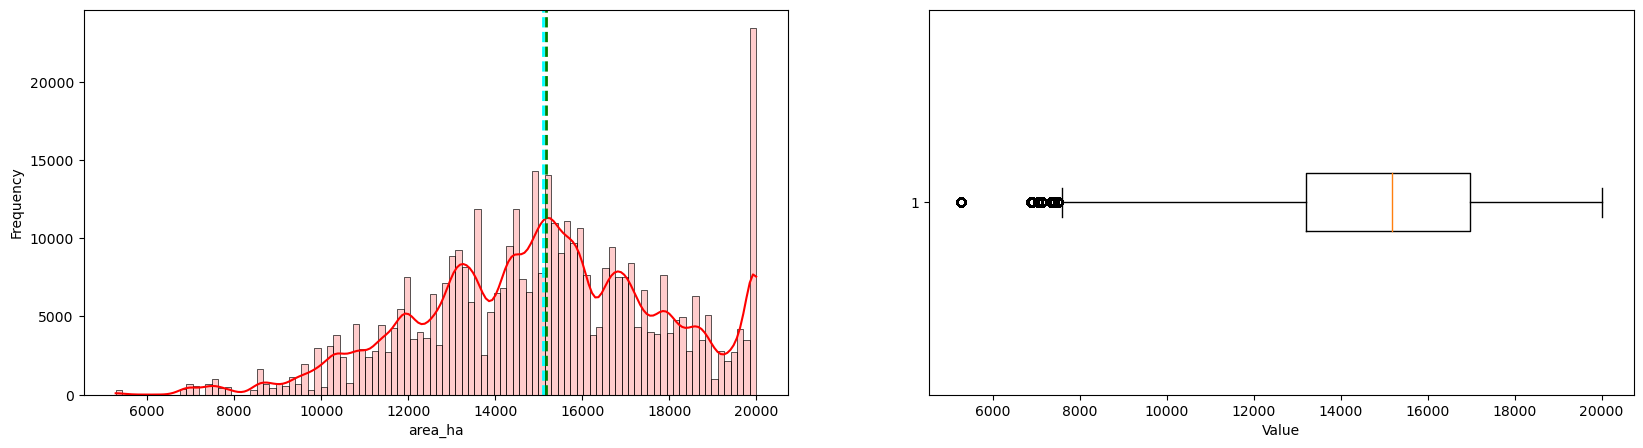

Column name: yield_quintals:
   Skewness: 0.18282911150759762
   Mean: 37.61358534239979


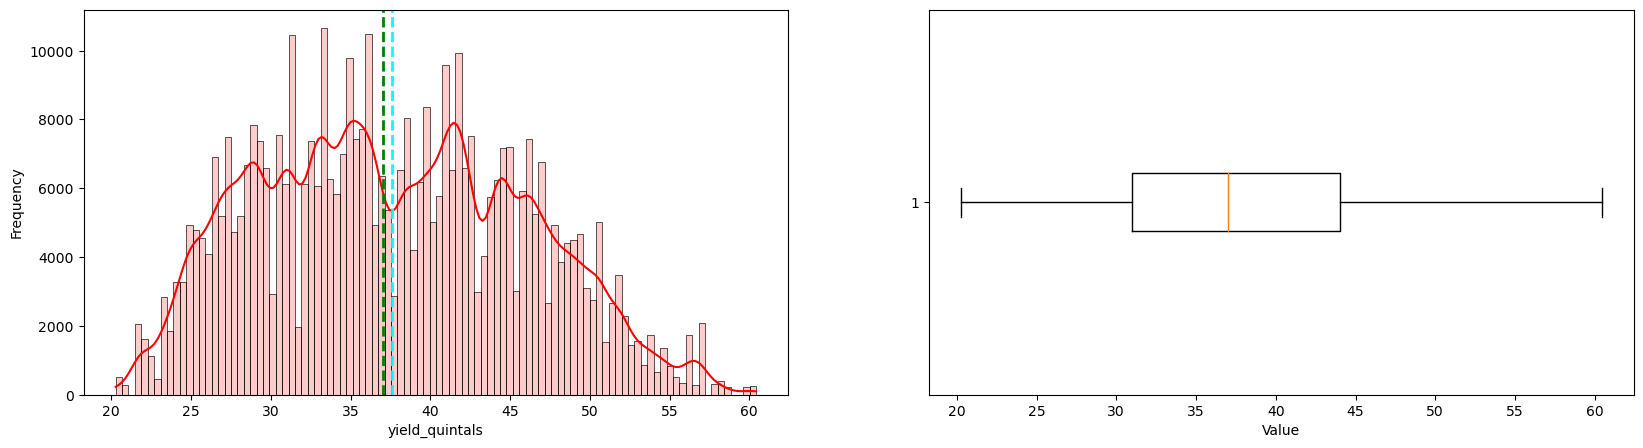

Column name: prodcution:
   Skewness: 0.3529504085498606
   Mean: 5675.128227879714


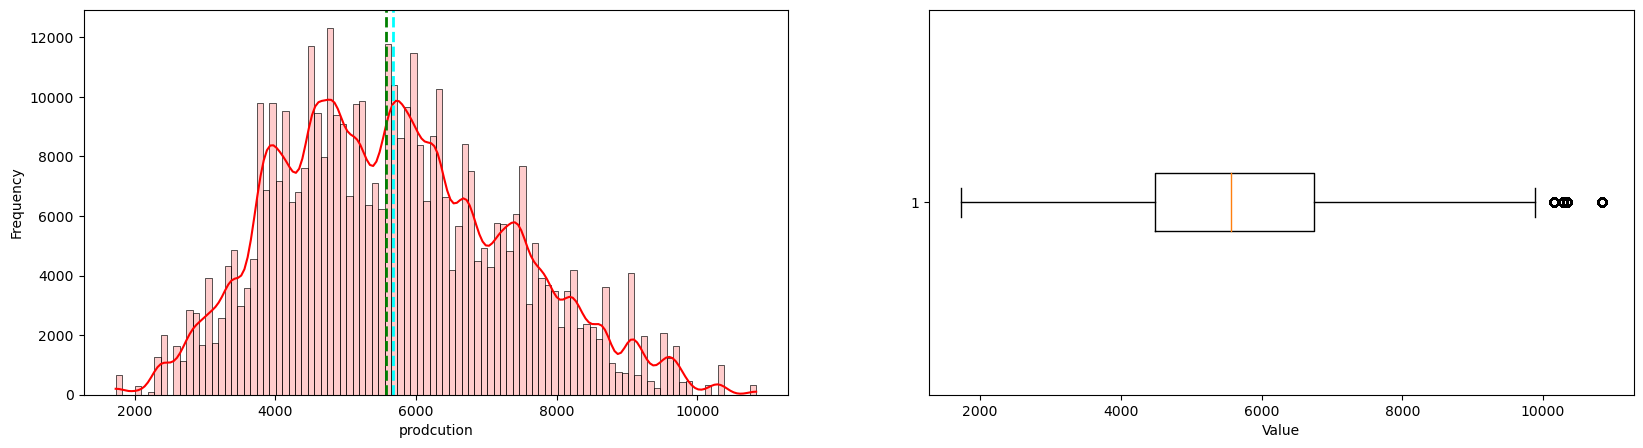

Column name: pH_level:
   Skewness: -0.057573743869440856
   Mean: 7.4981729132261785


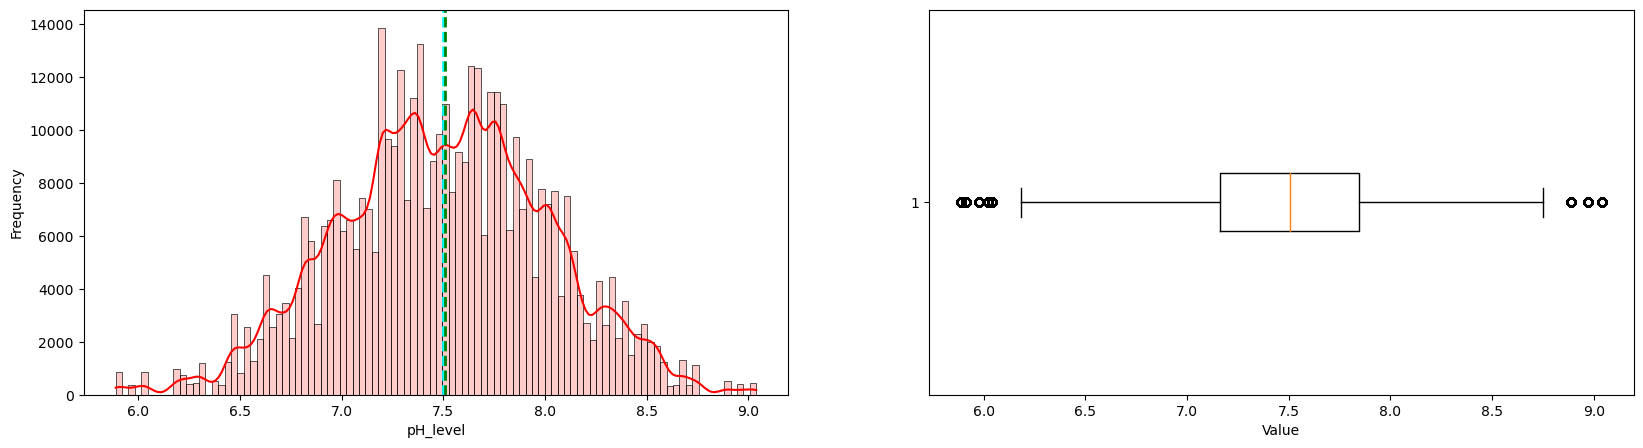

Column name: organic_matter_per:
   Skewness: 0.11935639244033999
   Mean: 1.9922173708067588


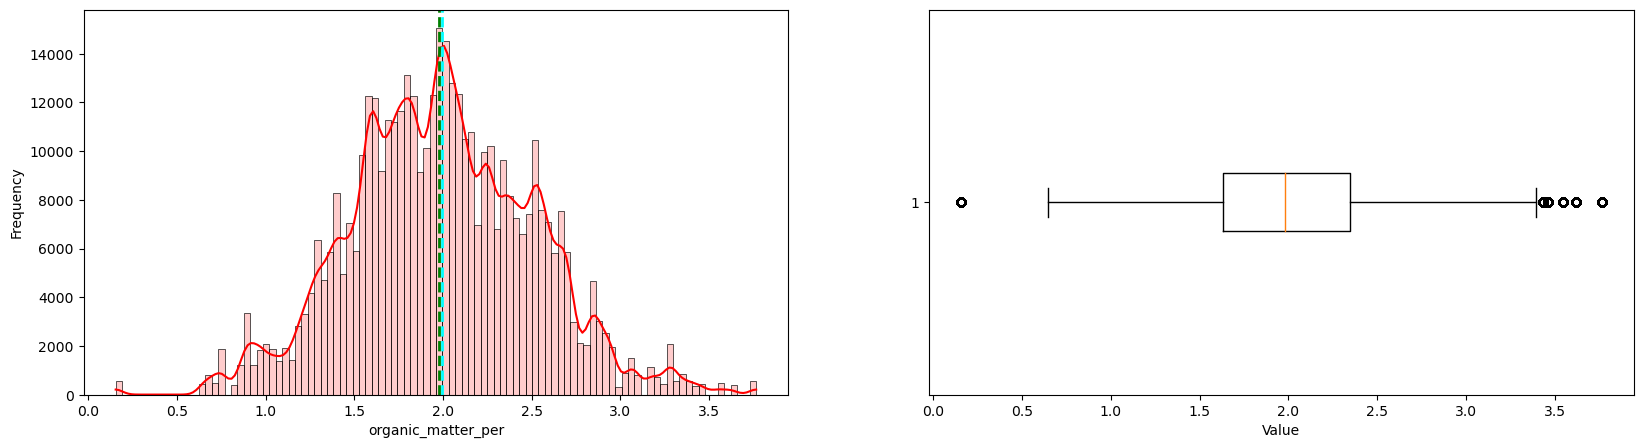

Column name: Nitrogen_kg_ha:
   Skewness: 0.0393243705995658
   Mean: 29.893850284900882


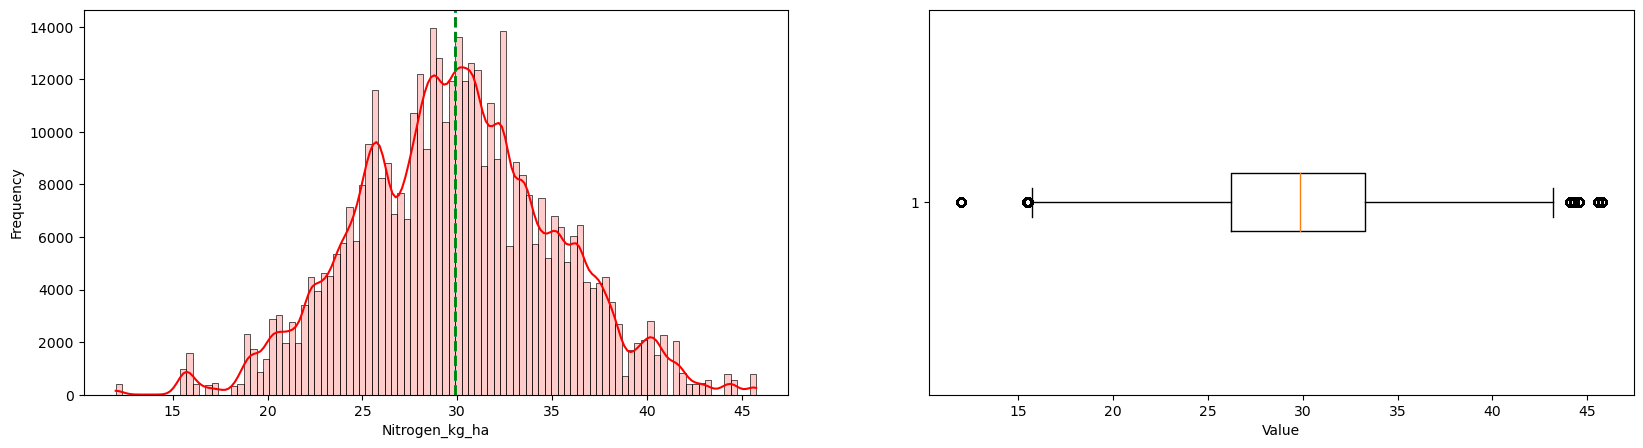

Column name: Phosphorous_kg_ha:
   Skewness: -0.052162637534092
   Mean: 19.73994580324203


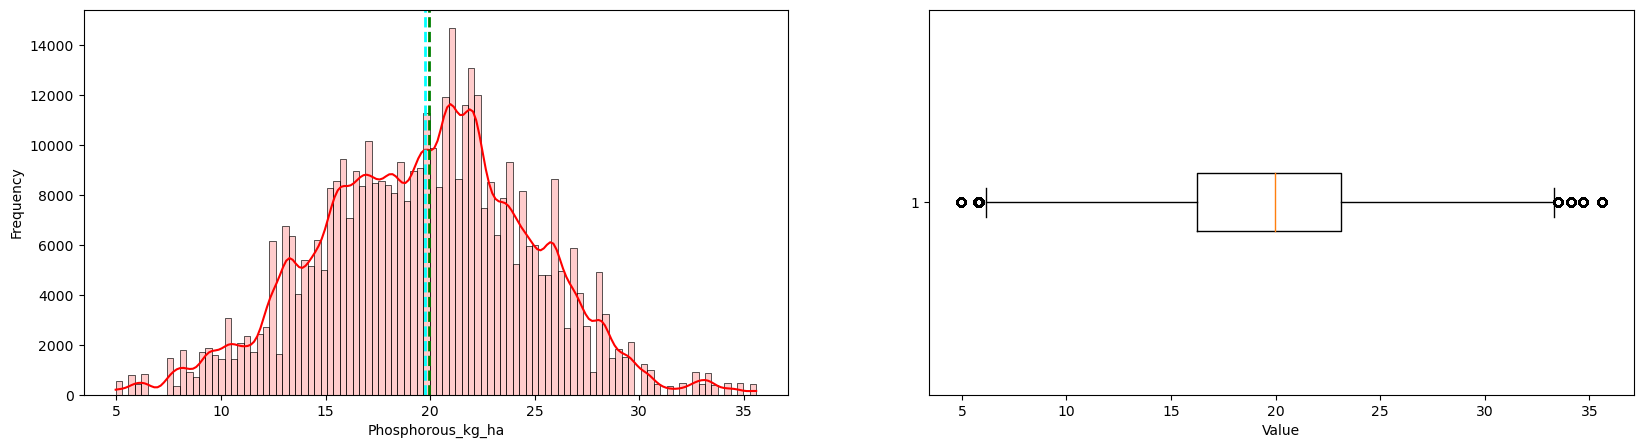

Column name: Potassium_kg_ha:
   Skewness: -0.019106946260801002
   Mean: 39.889615892685754


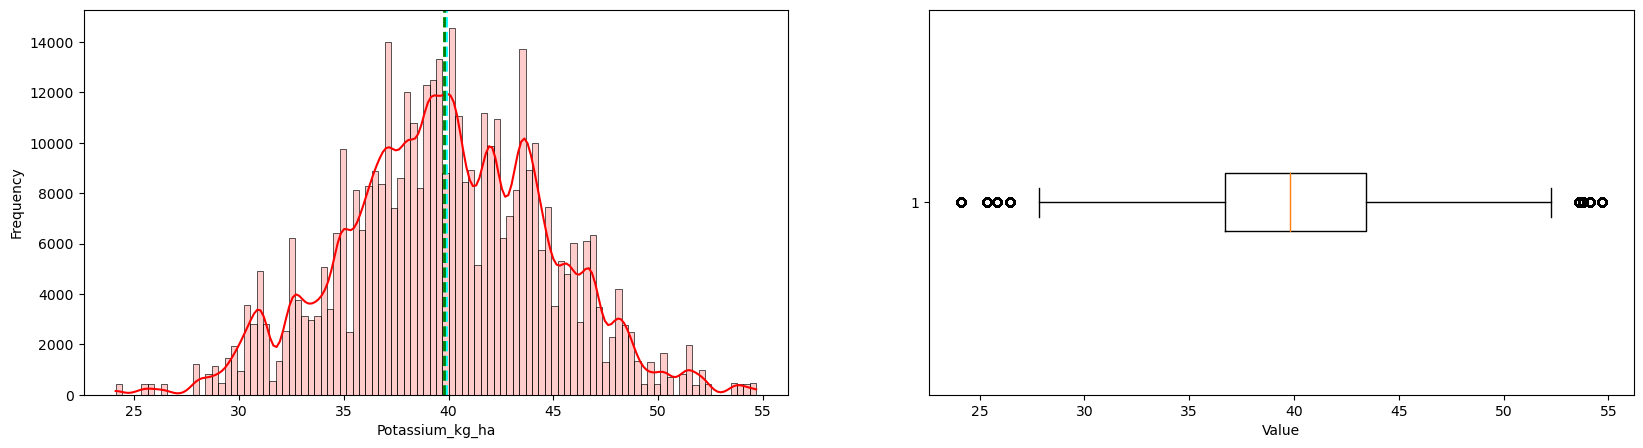

Column name: water_consumption_ltr_ha:
   Skewness: 0.16351491563955026
   Mean: 10491.911152133693


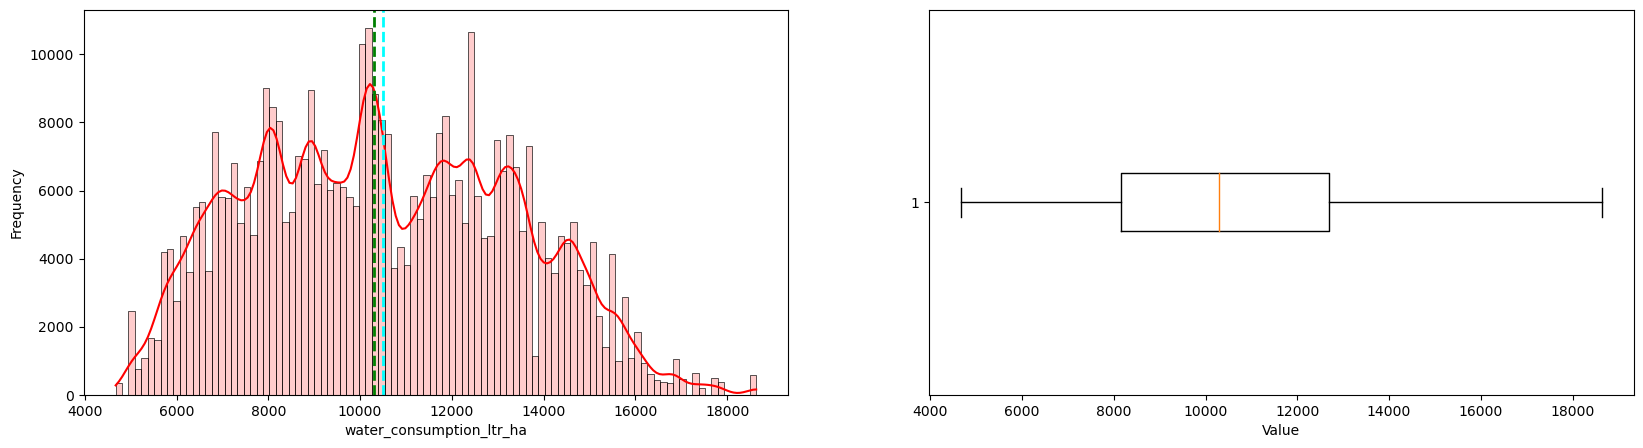

Column name: water_availability:
   Skewness: 0.1451696636887024
   Mean: 10476.802966840276


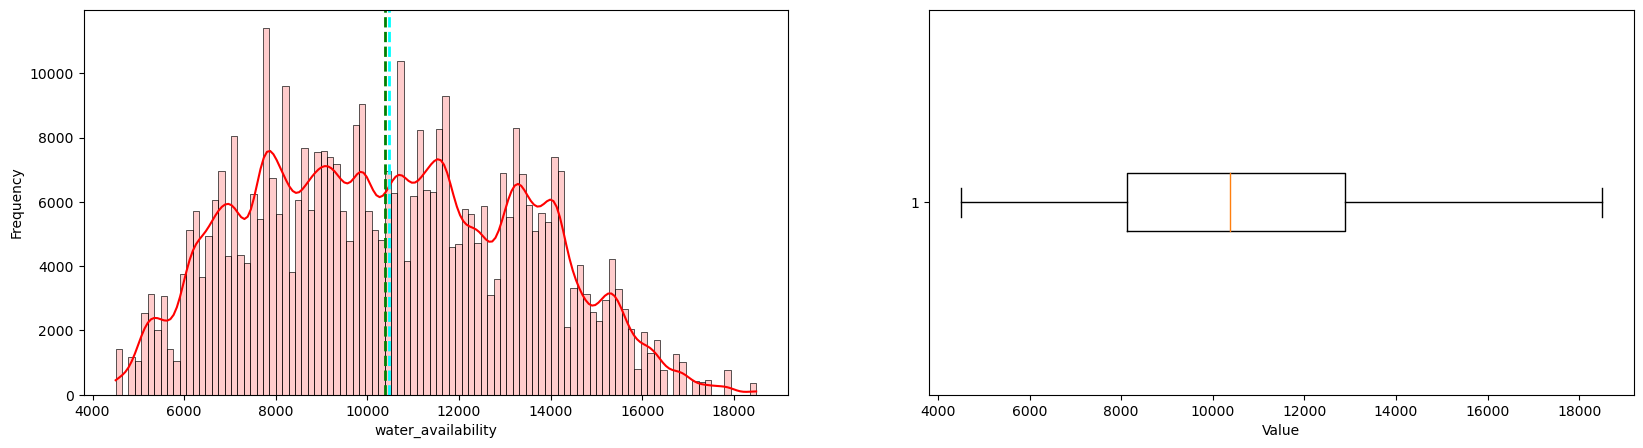

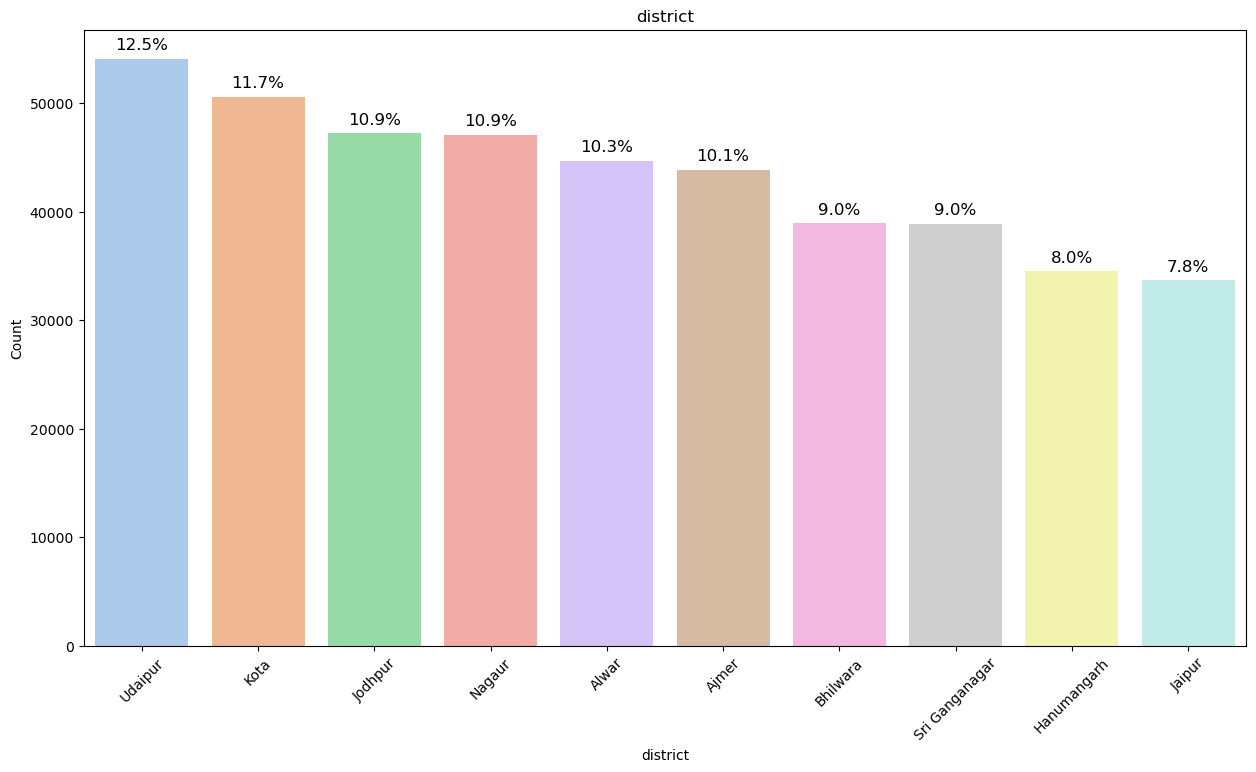

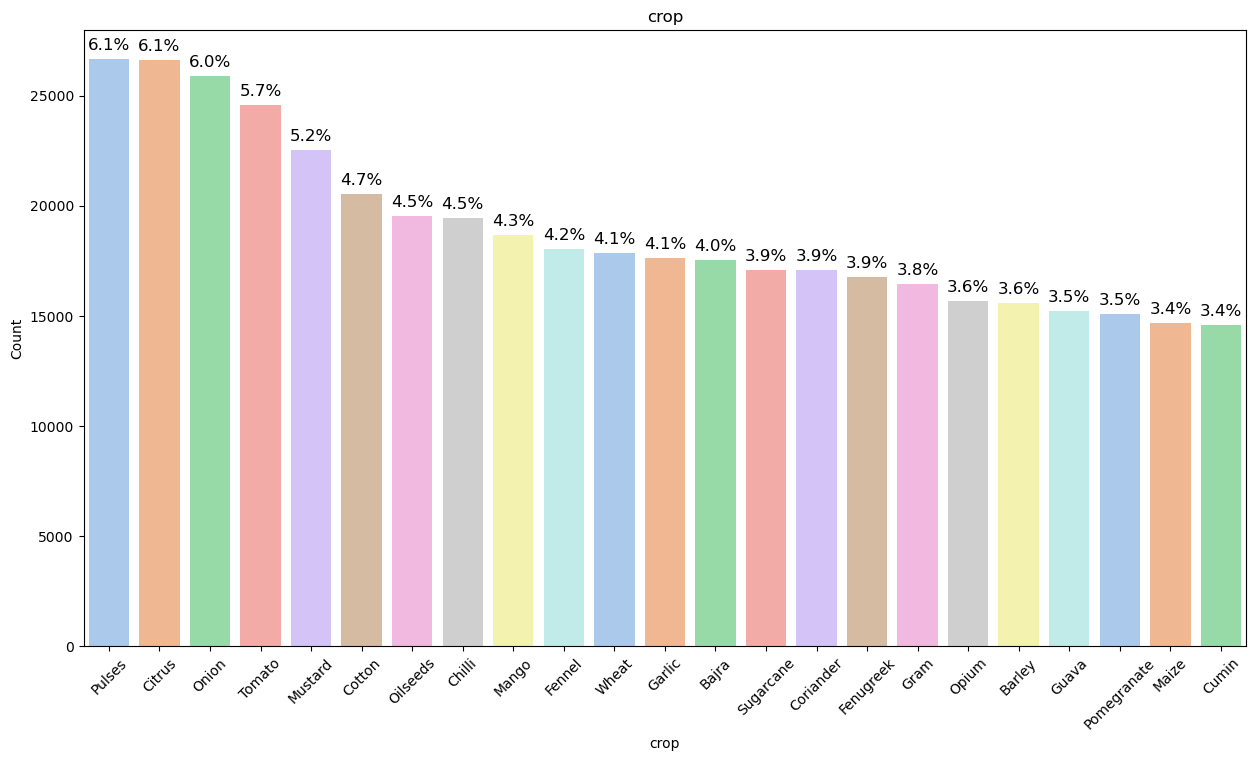

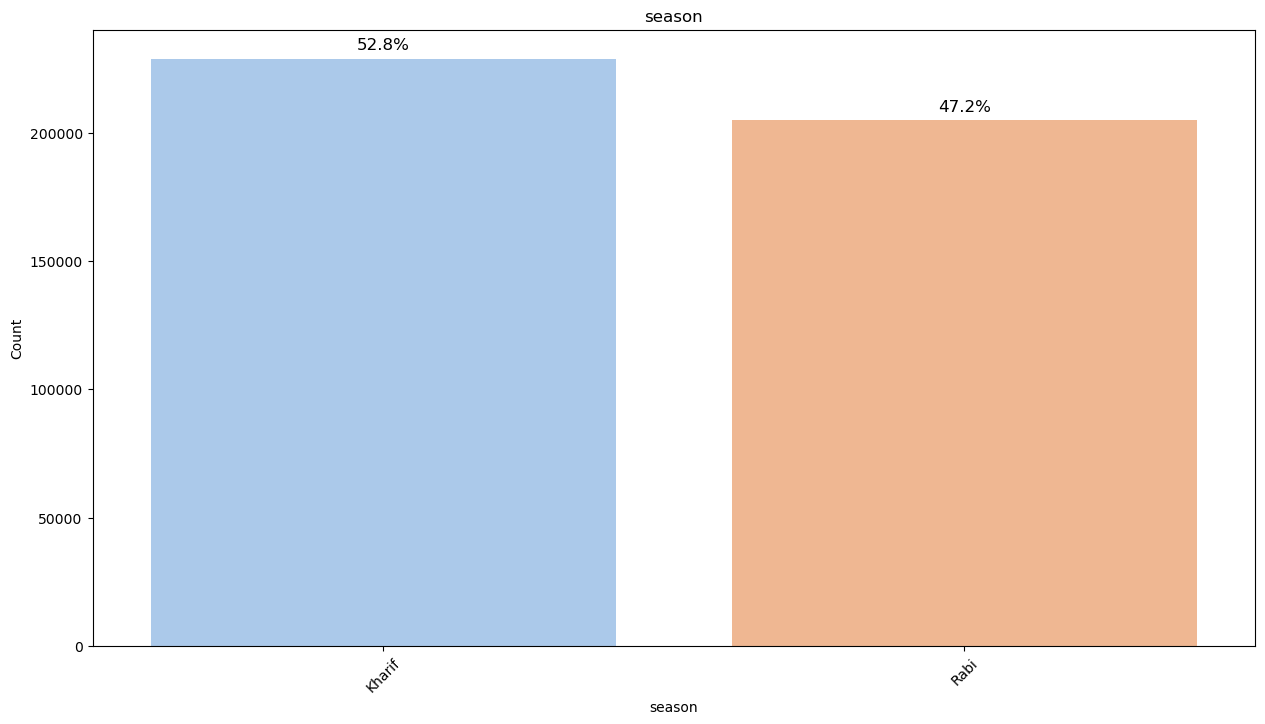

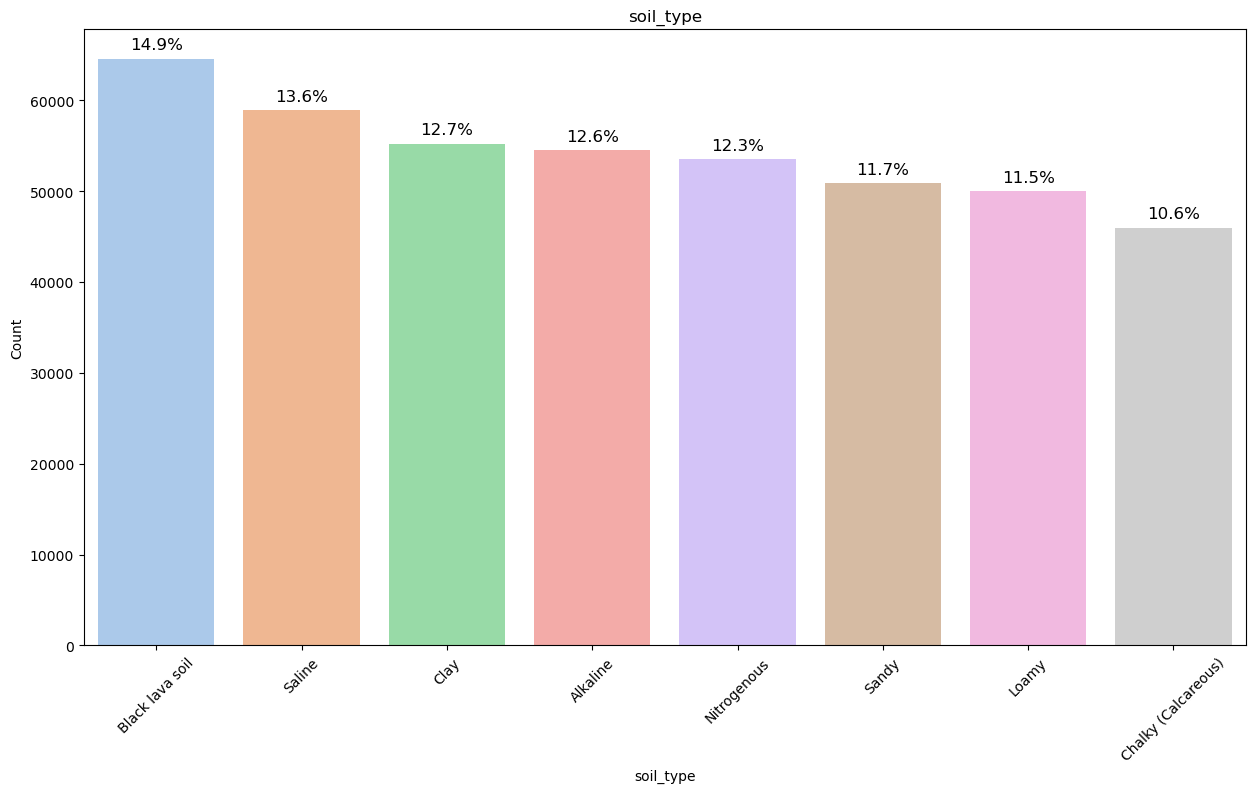

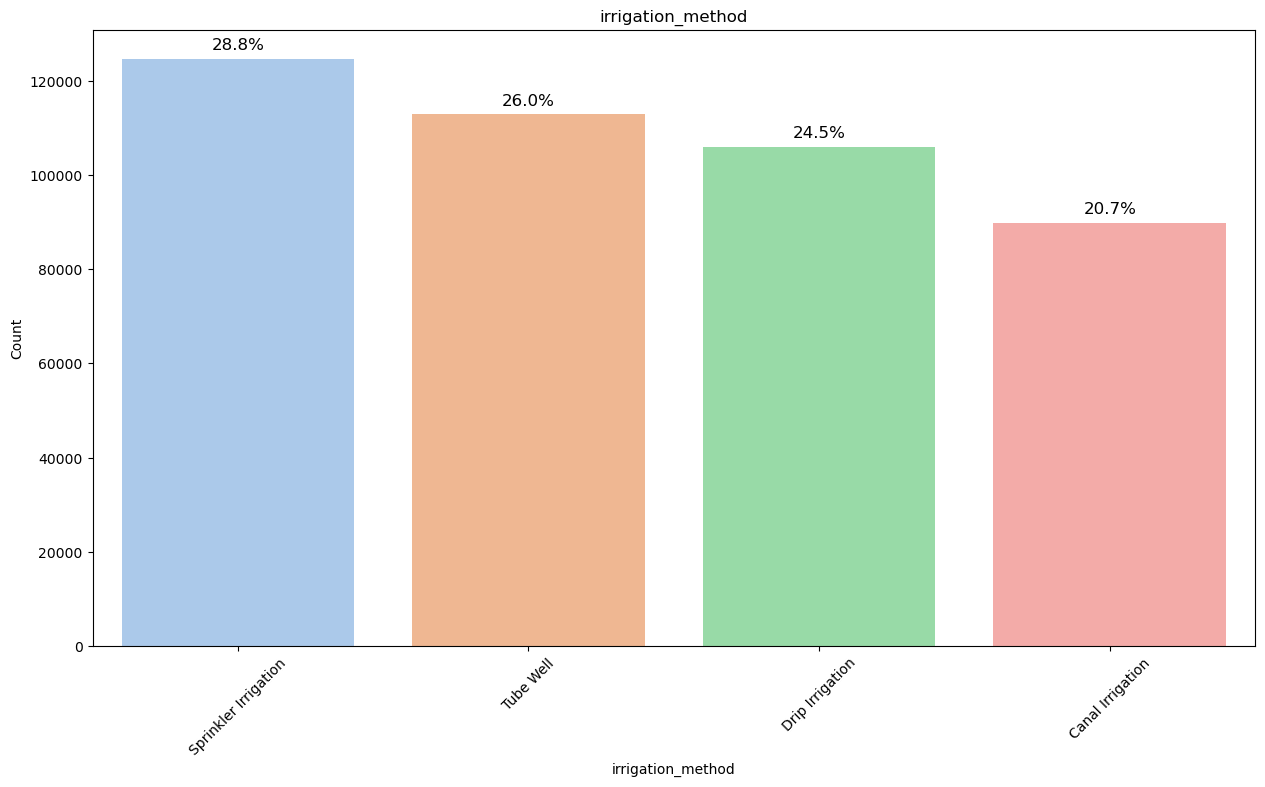

In [100]:
eda(df_merged)

In [124]:
df_transformed.shape

(417938, 23)

# Model Traning and Evaluation 

In [ ]:
def k_folds(model, df, k_fold, target_feat):
    """
    Performs k-fold cross-validation and returns the R2 score for each fold.

    Parameters:
        model: The machine learning model object (e.g., from scikit-learn).
        df (DataFrame): The input DataFrame containing the features and target variable.
        k_fold (int): The number of folds for cross-validation.
        target_feat (str): Name of the target variable in the DataFrame.

    Returns:
        r2_array (list): List of R2 scores for each fold.

    """

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop([target_feat], axis=1), df[target_feat], test_size=0.2, random_state=42)

    k = k_fold
    scoring = ['neg_mean_squared_error']

    # Perform k-fold cross-validation
    results = cross_validate(model, X_train, y_train, cv=k, scoring=scoring, return_estimator=True)
    trained_models = results['estimator']

    r2_array = []

    # Evaluate the R2 score for each fold
    for fold_idx, model in enumerate(trained_models):
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_array.append(r2)

    return r2_array


In [ ]:

def train_model_fn(model_name, model, df, target_feat):
    """
    Trains a machine learning model and evaluates its performance on train, validation, and test sets.

    Parameters:
        model_name (str): Name of the model.
        model: The machine learning model object (e.g., from scikit-learn).
        df (DataFrame): The input DataFrame containing the features and target variable.
        target_feat (str): Name of the target variable in the DataFrame.

    Returns:
        None (prints evaluation metrics).

    """

    # Split the data into train, validation, and test sets
    X_train, X_, y_train, y_ = train_test_split(df.drop([target_feat], axis=1), df[target_feat], test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    print("Model Name:", model_name)

    # Predict on the train set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Train set evaluation
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    print("Train set Evaluation")
    print(f"Mean Square Error: {mse_train:.4f}")
    print(f"Root Mean Square Error: {rmse_train:.4f}")
    print(f"R2 Score: {r2_train:.4f}")

    # Cross-validation set evaluation
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val, y_val_pred)

    print("Cross Validation set Evaluation")
    print(f"Mean Square Error: {mse_val:.4f}")
    print(f"Root Mean Square Error: {rmse_val:.4f}")
    print(f"R2 Score: {r2_val:.4f}")

    # K-fold implementation
    k_fold_r2_scores = k_folds(model, df, 5, target_feat)
    avg_r2_score = np.mean(k_fold_r2_scores)
    print(f"K-Folds average R2 Score: {avg_r2_score}")

    # Test set evaluation
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    print("Test set Evaluation")
    print(f"Mean Square Error: {mse_test:.4f}")
    print(f"Root Mean Square Error: {rmse_test:.4f}")
    print(f"R2 Score: {r2_test:.4f}")


In [105]:
dtrg_model = DecisionTreeRegressor(max_depth=10)
xgb_model = XGBRegressor()

In [122]:
train_model_fn('DecisionTreeRegressor', DecisionTreeRegressor(max_depth=10), df_transformed, 'water_consumption_ltr_ha')

Model Name : DecisionTreeRegressor
Train set Evaluation
Mean Square Error: 0.0045
Root Mean Square Error: 0.0674
R2 Score: 0.9955
Cress Validation set Evaluation
Mean Square Error: 0.0045
Root Mean Square Error: 0.0671
R2 Score: 0.9955
K_Folds average r2 Score: 0.9954967595161929
Test set Evaluation
Mean Square Error: 0.0045
Root Mean Square Error: 0.0669
R2 Score: 0.9956


In [123]:
train_model_fn('XGBRegressor', XGBRegressor(), df_transformed, 'water_consumption_ltr_ha')

Model Name : XGBRegressor
Train set Evaluation
Mean Square Error: 0.0011
Root Mean Square Error: 0.0327
R2 Score: 0.9989
Cress Validation set Evaluation
Mean Square Error: 0.0011
Root Mean Square Error: 0.0327
R2 Score: 0.9989
K_Folds average r2 Score: 0.998939813678612
Test set Evaluation
Mean Square Error: 0.0011
Root Mean Square Error: 0.0327
R2 Score: 0.9989
